In [1]:
import pandas as pd
import numpy as np
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.utils import resample

In [2]:
# Load data from CSV files
data = pd.read_csv("/path/to/your/directory/N.2012_ONLY.csv")
income_df = pd.read_csv("/path/to/your/directory/N.covariates.csv", low_memory=False)

# Drop unnecessary columns
data.drop(['hid_x', 'health'], axis=1, inplace=True)

In [16]:
# Define the years you want to calculate the CATE for
years = range(2013, 2021)

# Filter the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Initialize a list to store individuals present across all years
common_individuals = set(data_2011['pid'])

# Identify individuals present in all years
for year in years:
    income_year = income_df[income_df['syear'] == year]
    common_individuals &= set(income_year['pid'])

# Filter the 2011 data to only include common individuals
data_2011_common = data_2011[data_2011['pid'].isin(common_individuals)]

# Store results for each year
cate_results = {}
cate_results_scaled = {}
ci_lowers = []  # Initialize as a list
ci_uppers = []  # Initialize as a list

# Calculate the baseline mean income for 2011 for the common subset
baseline_mean_income = data_2011_common['gross_income'].mean()

# Loop through each year with the consistent subset
for year in years:
    # Filter the income data for the given year for common individuals
    income_year = income_df[(income_df['syear'] == year) & (income_df['pid'].isin(common_individuals))][['pid', 'gross_income']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011_common, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'gross_income_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean income
    cate_estimates_scaled = cate_estimates / baseline_mean_income
    
    # Store the results
    cate_results[year] = cate_estimates
    cate_results_scaled[year] = cate_estimates_scaled

    # Print scaled CATE estimates for the year
    print(f"Scaled CATE Estimates for {year}:")
    print(cate_estimates_scaled)

    # Define a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error for scaled estimates
    ci_lower = np.percentile(bootstrapped_cates, 2.5) / baseline_mean_income
    ci_upper = np.percentile(bootstrapped_cates, 97.5) / baseline_mean_income
    std_error = np.std(bootstrapped_cates) / baseline_mean_income

    # Store the confidence intervals
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

    print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    print(f"Standard Error for {year}: {std_error}")


Scaled CATE Estimates for 2013:
[ 0.00755863  0.02979237 -0.04204361 ... -0.02667019 -0.01766789
  0.02634955]
95% Confidence Interval for 2013: [-0.05816848485831162, -0.002237878009175562]
Standard Error for 2013: 0.014072184103951594
Scaled CATE Estimates for 2014:
[ 0.01992736  0.02566298  0.06742445 ...  0.03114214 -0.0064392
  0.00924331]
95% Confidence Interval for 2014: [-0.07921267978298839, -0.013470741248409569]
Standard Error for 2014: 0.018108689888567543
Scaled CATE Estimates for 2015:
[ 0.06072296 -0.087853    0.21085981 ...  0.04144675 -0.0179282
  0.11146221]
95% Confidence Interval for 2015: [-0.07544310278434943, -0.0017929447850921743]
Standard Error for 2015: 0.018724537313253135
Scaled CATE Estimates for 2016:
[ 0.08312171 -0.12371092  0.05450165 ...  0.05363055  0.02003105
  0.05282654]
95% Confidence Interval for 2016: [-0.08044241016978392, 0.003871919086093681]
Standard Error for 2016: 0.020939621533797963
Scaled CATE Estimates for 2017:
[ 0.04090329 -0.132617

In [15]:
# Count the number of individuals that are followed from 2011 to 2020
num_individuals_followed = len(common_individuals)
print(f"Number of individuals followed from 2011 to 2020: {num_individuals_followed}")

# Count the number of individuals in the treatment group (binary_treatment = 1)
num_treatment = data_2011_common[data_2011_common['binary_treatment'] == 1].shape[0]
print(f"Number of individuals in the treatment group: {num_treatment}")

Number of individuals followed from 2011 to 2020: 4133
Number of individuals in the treatment group: 1380


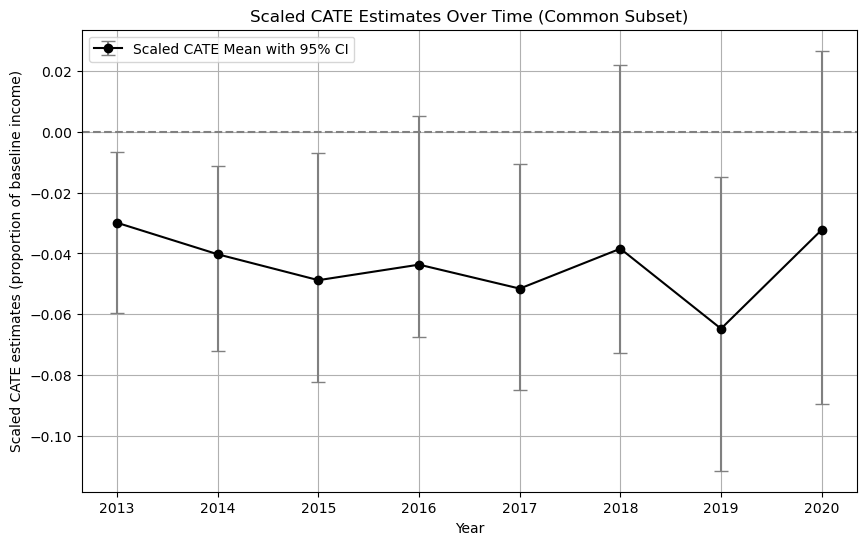

In [11]:
# Convert lists to numpy arrays for easy calculation of error bars
years = np.array(list(cate_results_scaled.keys()))
mean_cates_scaled = np.array([np.mean(cate_results_scaled[year]) for year in years])
ci_lowers = np.array(ci_lowers)
ci_uppers = np.array(ci_uppers)

# Calculate the error margins
error_bars = [mean_cates_scaled - ci_lowers, ci_uppers - mean_cates_scaled]

# Plotting the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_cates_scaled, yerr=error_bars, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Scaled CATE estimates (proportion of baseline income)')
plt.title('Scaled CATE Estimates Over Time (Common Subset)')
plt.xticks(years)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
# After the loop, display the mean CATE estimates for each year
print("Mean Scaled CATE Estimates for each year:")
for year in years:
    mean_cate = np.mean(cate_results_scaled[year])
    print(f"Year {year}: Mean Scaled CATE = {mean_cate:.4f}")


Mean Scaled CATE Estimates for each year:
Year 2013: Mean Scaled CATE = -0.0299
Year 2014: Mean Scaled CATE = -0.0403
Year 2015: Mean Scaled CATE = -0.0488
Year 2016: Mean Scaled CATE = -0.0437
Year 2017: Mean Scaled CATE = -0.0515
Year 2018: Mean Scaled CATE = -0.0384
Year 2019: Mean Scaled CATE = -0.0647
Year 2020: Mean Scaled CATE = -0.0322


In [14]:
from scipy.stats import t

t_values = []  # Initialize list to store t-values
p_values = []  # Initialize list to store p-values

for i, year in enumerate(years):
    # Calculate the mean of the scaled CATE estimates for the year
    mean_cate_scaled = np.mean(cate_results_scaled[year])
    
    # Estimate the standard error from the confidence intervals
    std_error = (ci_uppers[i] - ci_lowers[i]) / (2 * 1.96)  # Assuming 95% CI
    
    # Calculate the t-value
    t_value = mean_cate_scaled / std_error
    t_values.append(t_value)
    
    # Calculate the p-value using the t-distribution
    p_value = 2 * (1 - t.cdf(abs(t_value), df=len(cate_results_scaled[year]) - 1))
    p_values.append(p_value)
    
    print(f"Year {year}:")
    print(f"  t-value: {t_value}")
    print(f"  p-value: {p_value}")


Year 2013:
  t-value: -2.227644504204194
  p-value: 0.025982291574353722
Year 2014:
  t-value: -2.6047576797906116
  p-value: 0.009242855110381365
Year 2015:
  t-value: -2.536146076943543
  p-value: 0.011263074601320033
Year 2016:
  t-value: -2.357184998163848
  p-value: 0.01848489435720957
Year 2017:
  t-value: -2.7265940684823997
  p-value: 0.006441479100677494
Year 2018:
  t-value: -1.5944166544448266
  p-value: 0.11096470991087326
Year 2019:
  t-value: -2.6322349231784377
  p-value: 0.008533433147461134
Year 2020:
  t-value: -1.0874271374710247
  p-value: 0.27695337341058734


In [28]:
# IMPACT ON WORKING HOURS

In [22]:
# Define the years you want to calculate the CATE for
years = range(2013, 2021)

# Filter the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Initialize a list to store individuals present across all years
common_individuals = set(data_2011['pid'])

# Identify individuals present in all years
for year in years:
    income_year = income_df[income_df['syear'] == year]
    common_individuals &= set(income_year['pid'])

# Filter the 2011 data to only include common individuals
data_2011_common = data_2011[data_2011['pid'].isin(common_individuals)]

# Store results for each year
cate_results_wh = {}
cate_results_scaled_wh = {}
ci_lowers = []  # Initialize as a list
ci_uppers = []  # Initialize as a list

# Calculate the baseline mean working hours for 2011 for the common subset
baseline_mean_working_hours = data_2011_common['working_hours'].mean()

# Loop through each year with the consistent subset
for year in years:
    # Filter the working hours data for the given year for common individuals
    working_hours_year = income_df[(income_df['syear'] == year) & (income_df['pid'].isin(common_individuals))][['pid', 'working_hours']]
    
    # Merge the working hours data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011_common, working_hours_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'working_hours_2011','gross_income', 'lf_status', 'binary_treatment', f'working_hours_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income','working_hours_2011', 'lf_status']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'working_hours_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates_wh = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean working hours
    cate_estimates_scaled_wh = cate_estimates_wh / baseline_mean_working_hours
    
    # Store the results
    cate_results_wh[year] = cate_estimates_wh
    cate_results_scaled_wh[year] = cate_estimates_scaled_wh

    # Print scaled CATE estimates for the year
    print(f"Scaled CATE Estimates for {year}:")
    print(cate_estimates_scaled_wh)

    # Define a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error for scaled estimates
    ci_lower = np.percentile(bootstrapped_cates, 2.5) / baseline_mean_working_hours
    ci_upper = np.percentile(bootstrapped_cates, 97.5) / baseline_mean_working_hours
    std_error = np.std(bootstrapped_cates) / baseline_mean_working_hours

    # Store the confidence intervals
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

    print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    print(f"Standard Error for {year}: {std_error}")


Scaled CATE Estimates for 2013:
[-0.00825786 -0.00554692 -0.11650514 ... -0.00730165 -0.02687907
 -0.0020926 ]
95% Confidence Interval for 2013: [-0.04387515406286152, -0.013733284654673942]
Standard Error for 2013: 0.007912855679552456
Scaled CATE Estimates for 2014:
[-0.05201097 -0.00765331 -0.06860364 ... -0.0148907   0.01932985
  0.00672828]
95% Confidence Interval for 2014: [-0.03712519487263885, -0.009109369007603861]
Standard Error for 2014: 0.0073047515065054166
Scaled CATE Estimates for 2015:
[-0.08932244 -0.01966006 -0.10772504 ... -0.02886161 -0.07133333
  0.00396764]
95% Confidence Interval for 2015: [-0.04381374632499004, -0.00812332853396703]
Standard Error for 2015: 0.009126255513224834
Scaled CATE Estimates for 2016:
[ 0.00564518 -0.00602764 -0.06310051 ...  0.00410626 -0.08777316
 -0.00308004]
95% Confidence Interval for 2016: [-0.046018007370455416, -0.013532021780729849]
Standard Error for 2016: 0.008499782684686215
Scaled CATE Estimates for 2017:
[ 0.04093748 -0.025

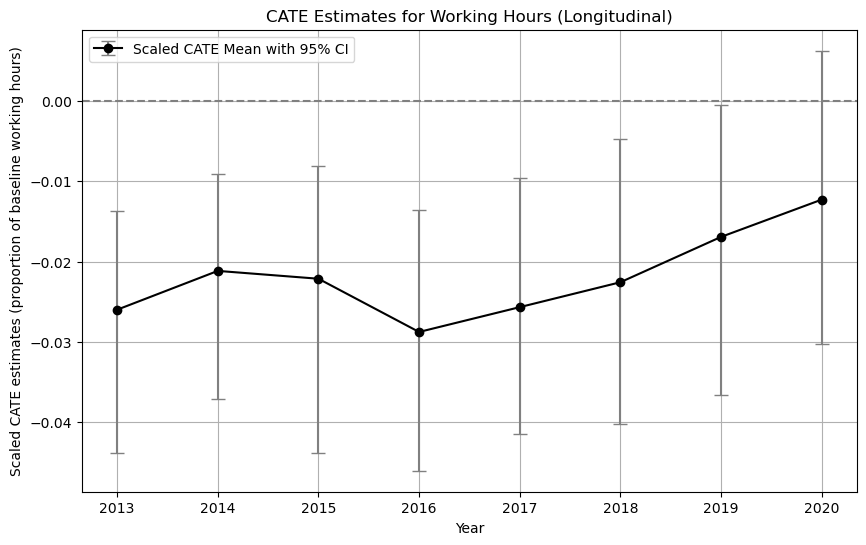

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Convert years to a list
years_list = list(years)

# Calculate the mean of the scaled CATE estimates for each year
mean_cates_scaled_wh = [np.mean(cate_results_scaled_wh[year]) for year in years_list]

# Calculate the error margins (confidence intervals)
error_bars = [(mean_cates_scaled_wh[i] - ci_lowers[i], ci_uppers[i] - mean_cates_scaled_wh[i]) for i in range(len(years_list))]

# Unzip the error bars into lower and upper bounds
lower_bounds, upper_bounds = zip(*error_bars)

# Plotting the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(years_list, mean_cates_scaled_wh, yerr=[lower_bounds, upper_bounds], fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Scaled CATE estimates (proportion of baseline working hours)')
plt.title('CATE Estimates for Working Hours (Longitudinal)')
plt.xticks(years_list)
plt.grid(True)
plt.legend()
plt.show()

In [24]:
# Calculate mean scaled CATE estimates for each year
mean_cates_scaled_wh = {}
for year in years:
    mean_cates_scaled_wh[year] = np.mean(cate_results_scaled_wh[year])
    print(f"Year {year}: Mean Scaled CATE = {mean_cates_scaled_wh[year]:.4f}")


Year 2013: Mean Scaled CATE = -0.0260
Year 2014: Mean Scaled CATE = -0.0212
Year 2015: Mean Scaled CATE = -0.0221
Year 2016: Mean Scaled CATE = -0.0288
Year 2017: Mean Scaled CATE = -0.0257
Year 2018: Mean Scaled CATE = -0.0226
Year 2019: Mean Scaled CATE = -0.0169
Year 2020: Mean Scaled CATE = -0.0123


In [25]:
from scipy.stats import t

# Initialize lists to store t-values and p-values
t_values_wh = []
p_values_wh = []

# Iterate over each year to calculate the t-values and p-values
for i, year in enumerate(years):
    # Calculate the mean of the scaled CATE estimates for the year
    mean_cate_scaled_wh = np.mean(cate_results_scaled_wh[year])
    
    # Estimate the standard error from the confidence intervals
    std_error_wh = (ci_uppers[i] - ci_lowers[i]) / (2 * 1.96)  # Assuming 95% CI
    
    # Calculate the t-value
    t_value_wh = mean_cate_scaled_wh / std_error_wh
    t_values_wh.append(t_value_wh)
    
    # Calculate the p-value using the t-distribution
    p_value_wh = 2 * (1 - t.cdf(abs(t_value_wh), df=len(cate_results_scaled_wh[year]) - 1))
    p_values_wh.append(p_value_wh)
    
    print(f"Year {year}:")
    print(f"  t-value: {t_value_wh}")
    print(f"  p-value: {p_value_wh}")



Year 2013:
  t-value: -3.380690852645931
  p-value: 0.0007331766108467086
Year 2014:
  t-value: -2.961744982736763
  p-value: 0.0030858123680770344
Year 2015:
  t-value: -2.4319113645261528
  p-value: 0.015085660890161945
Year 2016:
  t-value: -3.4707170744590843
  p-value: 0.0005274480489592115
Year 2017:
  t-value: -3.1641953922176698
  p-value: 0.0015734462729857235
Year 2018:
  t-value: -2.4915817707074965
  p-value: 0.012781746433032204
Year 2019:
  t-value: -1.8421945910888087
  p-value: 0.06556648847741653
Year 2020:
  t-value: -1.3222762155498944
  p-value: 0.18620161282050374


In [31]:
# WORKING HOURS NOT LONGITUDINAL

In [34]:
#SCALING CATE ESTIMATES - RESULTS IN % of BASELINE INCOME

# Define the years you want to calculate the CATE for
years = range(2013, 2021)

# Store results for each year
cate_results_wh_nl = {}
cate_results_scaled_wh_nl = {}

# Calculate the baseline mean income for 2011
baseline_mean_hours = data_2011['working_hours'].mean()

# Loop through each year
for year in years:
    # Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'working_hours']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'working_hours_2011', 'gross_income', 'lf_status', 'binary_treatment', f'working_hours_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income', 'lf_status', 'working_hours_2011']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'working_hours_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates_wh_nl = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean income
    cate_estimates_scaled_wh_nl = cate_estimates_wh_nl / baseline_mean_hours
    
    # Store the results
    cate_results_wh_nl[year] = cate_estimates_wh_nl
    cate_results_scaled_wh_nl[year] = cate_estimates_scaled_wh_nl

    # Print scaled CATE estimates for the year
    print(f"Scaled CATE Estimates for {year}:")
    print(cate_estimates_scaled_wh_nl)

    # Define a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error for scaled estimates
    ci_lower = np.percentile(bootstrapped_cates, 2.5) / baseline_mean_hours
    ci_upper = np.percentile(bootstrapped_cates, 97.5) / baseline_mean_hours
    std_error = np.std(bootstrapped_cates) / baseline_mean_hours

    print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    print(f"Standard Error for {year}: {std_error}")


Scaled CATE Estimates for 2013:
[-0.01965483 -0.0007972  -0.00993989 ... -0.05332363 -0.01622031
  0.00039998]
95% Confidence Interval for 2013: [-0.03440464880575345, -0.014583843282051286]
Standard Error for 2013: 0.005137796994300429
Scaled CATE Estimates for 2014:
[-0.0104427  -0.03731953 -0.00698351 ... -0.00934459  0.0072845
 -0.0144582 ]
95% Confidence Interval for 2014: [-0.03757873101965837, -0.013384596549981387]
Standard Error for 2014: 0.00645794733922544
Scaled CATE Estimates for 2015:
[-0.02971177 -0.05696429 -0.01199073 ... -0.04248981 -0.01119981
  0.02466481]
95% Confidence Interval for 2015: [-0.04066965039939245, -0.014264399823784413]
Standard Error for 2015: 0.00682476156083009
Scaled CATE Estimates for 2016:
[-0.04185195  0.00769191 -0.00449924 ... -0.13337614 -0.02508517
  0.00143501]
95% Confidence Interval for 2016: [-0.03878030301633985, -0.010900388147539066]
Standard Error for 2016: 0.0073422622030663
Scaled CATE Estimates for 2017:
[-0.04544378  0.03452833 

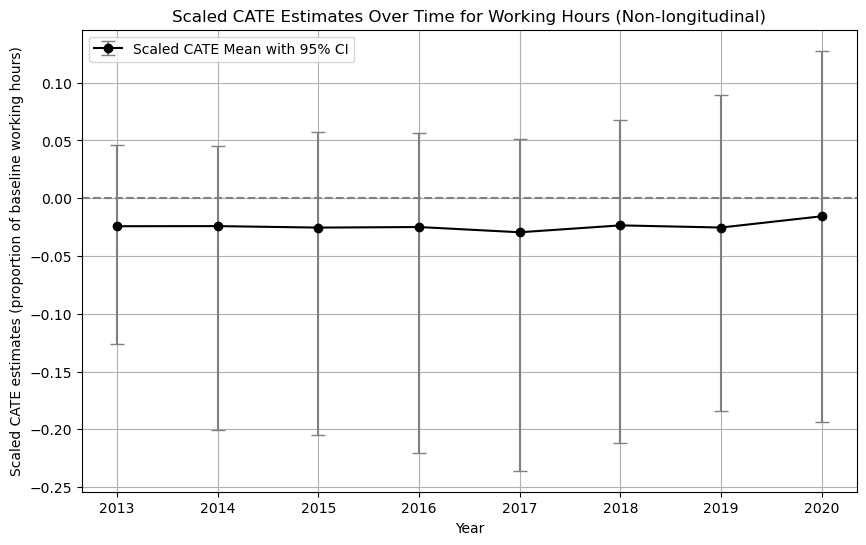

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Convert years to a list
years = list(cate_results_scaled_wh_nl.keys())

# Calculate the mean of the scaled CATE estimates for each year
mean_cates_scaled_wh_nl = [np.mean(cate_results_scaled_wh_nl[year]) for year in years]

# Calculate the confidence intervals for each year
ci_lowers = []
ci_uppers = []
for year in years:
    bootstrapped_cates_wh_nl = cate_results_scaled_wh_nl[year]  # This should be the actual bootstrapped CATE estimates
    ci_lower = np.percentile(bootstrapped_cates_wh_nl, 2.5)  # Use the correct variable here
    ci_upper = np.percentile(bootstrapped_cates_wh_nl, 97.5) # Use the correct variable here
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

# Convert lists to numpy arrays for easy calculation of error bars
years = np.array(years)
mean_cates_scaled_wh_nl = np.array(mean_cates_scaled_wh_nl)
ci_lowers = np.array(ci_lowers)
ci_uppers = np.array(ci_uppers)

# Calculate the error margins
error_bars = [mean_cates_scaled_wh_nl - ci_lowers, ci_uppers - mean_cates_scaled_wh_nl]

# Plotting the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_cates_scaled_wh_nl, yerr=error_bars, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Scaled CATE estimates (proportion of baseline working hours)')
plt.title('Scaled CATE Estimates Over Time for Working Hours (Non-longitudinal)')
plt.xticks(years)
plt.grid(True)
plt.legend()
plt.show()


In [42]:
# Calculate mean scaled CATE estimates for each year
mean_cates_scaled_wh_nl = {}
for year in years:
    mean_cates_scaled_wh_nl[year] = np.mean(cate_results_scaled_wh_nl[year])
    print(f"Year {year}: Mean Scaled CATE = {mean_cates_scaled_wh_nl[year]:.4f}")

Year 2013: Mean Scaled CATE = -0.0243
Year 2014: Mean Scaled CATE = -0.0242
Year 2015: Mean Scaled CATE = -0.0254
Year 2016: Mean Scaled CATE = -0.0249
Year 2017: Mean Scaled CATE = -0.0295
Year 2018: Mean Scaled CATE = -0.0235
Year 2019: Mean Scaled CATE = -0.0254
Year 2020: Mean Scaled CATE = -0.0156


In [40]:
from scipy.stats import t

# Lists to store t-values and p-values for each year
t_values_wh_nl = []
p_values_wh_nl = []

# Loop through each year
for year in years:
    print(f"Calculating t-value and p-value for year {year}...")

    # Calculate the mean of the scaled CATE estimates for the year
    mean_cate_scaled_wh_nl = np.mean(cate_results_scaled_wh_nl[year])
    
    # Calculate the t-value
    t_value_wh_nl = mean_cate_scaled_wh_nl / std_error  # Use the standard error from your bootstrapping
    t_values_wh_nl.append(t_value_wh_nl)
    
    # Calculate the p-value using the t-distribution
    df_wh_nl = len(cate_results_scaled_wh_nl[year]) - 1  # degrees of freedom
    p_value_wh_nl = 2 * (1 - t.cdf(abs(t_value_wh_nl), df=df_wh_nl))
    p_values_wh_nl.append(p_value_wh_nl)
    

# Optionally, you can print all t-values and p-values at the end
print("\nSummary of t-values and p-values for all years:")
for i, year in enumerate(years):
    print(f"Year {year}: t-value = {t_values_wh_nl[i]}, p-value = {p_values_wh_nl[i]}")


Calculating t-value and p-value for year 2013...
Calculating t-value and p-value for year 2014...
Calculating t-value and p-value for year 2015...
Calculating t-value and p-value for year 2016...
Calculating t-value and p-value for year 2017...
Calculating t-value and p-value for year 2018...
Calculating t-value and p-value for year 2019...
Calculating t-value and p-value for year 2020...

Summary of t-values and p-values for all years:
Year 2013: t-value = -2.9113110392367325, p-value = 0.003613076077585209
Year 2014: t-value = -2.8994196232267306, p-value = 0.0037547021727002416
Year 2015: t-value = -3.0530077769769064, p-value = 0.0022785951169732588
Year 2016: t-value = -2.9944750790033345, p-value = 0.0027653989155040914
Year 2017: t-value = -3.539148657156667, p-value = 0.000406208278670217
Year 2018: t-value = -2.8228118333460355, p-value = 0.00478767001698488
Year 2019: t-value = -3.046338600177482, p-value = 0.002336188781367987
Year 2020: t-value = -1.8783337266302071, p-valu